# Timeseries anomaly detection using an Autoencoder

**Author:** [pavithrasv](https://github.com/pavithrasv)<br>
**Date created:** 2020/05/31<br>
**Last modified:** 2022/03/27 By B. Poczos<br>
**Description:** Detect anomalies in a timeseries using an Autoencoder.

## Introduction

This script demonstrates how you can use a convolutional
autoencoder model to **detect anomalies in timeseries** data.

In [1]:
!nvidia-smi

Sun Mar 27 16:03:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Setup

In [2]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

## Load the data

We will use the [Numenta Anomaly Benchmark(NAB)](
https://www.kaggle.com/boltzmannbrain/nab) dataset. 

The Numenta Anomaly Benchmark (NAB) is a benchmark for evaluating algorithms for anomaly detection in streaming, online applications. 

It is comprised of over **50 labeled real-world and artificial timeseries data** files.

The data contains labeled anomalous periods of behavior. Data are
ordered, timestamped, single-valued metrics.

**Examples**: 
* ambient_temperature_system_failure.csv: The ambient temperature in an office setting.

* cpu_utilization_asg_misconfiguration.csv: From Amazon Web Services (AWS)
monitoring CPU usage – i.e. average CPU usage across a given cluster. When
usage is high, AWS spins up a new machine, and uses fewer machines when usage
is low.

* machine_temperature_system_failure.csv: Temperature sensor data of an
internal component of a large, industrial mahcine. The first anomaly is a
planned shutdown of the machine. The second anomaly is difficult to detect and
directly led to the third anomaly, a catastrophic failure of the machine.
* nyc_taxi.csv: Number of NYC taxi passengers, where the five anomalies occur
during the NYC marathon, Thanksgiving, Christmas, New Years day, and a snow
storm. The raw data is from the NYC Taxi and Limousine Commission.
The data file included here consists of aggregating the total number of
taxi passengers into 30 minute buckets.

We will use the **`art_daily_small_noise.csv`** file for training and the
**`art_daily_jumpsup.csv`** file for testing. The simplicity of this dataset
allows us to demonstrate anomaly detection effectively.

**Load the data with pandas**

In [4]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

## Quick look at the data

In [5]:
print(df_small_noise.head())

print(df_daily_jumpsup.head())

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


## Visualize the data
### Timeseries data without anomalies

We will use the following data for training. This will be our normal data.

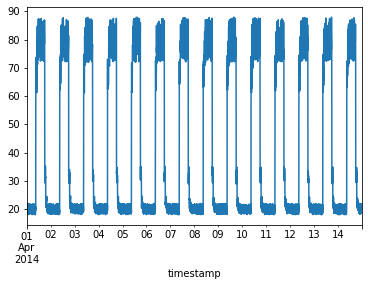

In [6]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()

### Timeseries data with anomalies

We will use the following data for testing and see if the sudden jump up in the
data is detected as an anomaly.

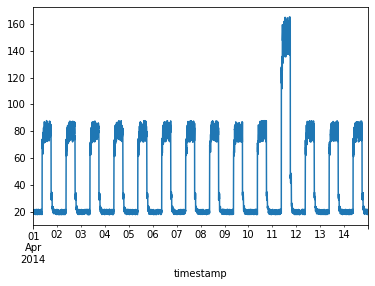

In [7]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

## Prepare training data

Get data values from the training timeseries data file and normalize the
`value` data. We have a `value` for every 5 mins for 14 days.

-   24 * 60 / 5 = **288 timesteps per day**
-   288 * 14 = **4032 data points** in total

In [8]:

# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


**Plot the normalized data**

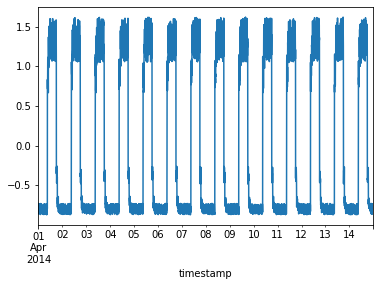

In [9]:
fig, ax = plt.subplots()
df_training_value.plot(legend=False, ax=ax)
plt.show()

### Create sequences
Create sequences combining `TIME_STEPS` contiguous data values from the
training data.

In [10]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3745, 288, 1)


**Plot some of the time series in the training data**

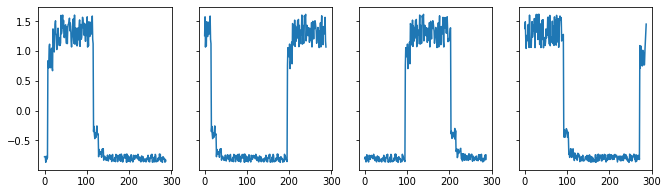

In [24]:
fig, ax = plt.subplots(1, 4,figsize=(11, 3), sharey=True)
ax[0].plot(x_train[100,:])
ax[1].plot(x_train[200,:])
ax[2].plot(x_train[300,:])
ax[3].plot(x_train[700,:])

## Build a model

We will build a **convolutional autoencoder** model. The model will
take input of shape `(batch_size, sequence_length, num_features)` and return
output of the same shape. In this case, `sequence_length` is 288 and
`num_features` is 1.

In [27]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)


In [28]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 144, 32)           256       
                                                                 
 dropout_2 (Dropout)         (None, 144, 32)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 144, 16)          1808      
 ranspose)                                                       
                                                                 
 dropout_3 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                            

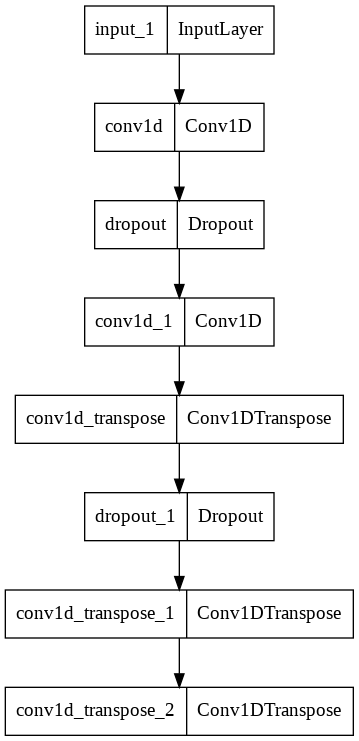

In [26]:
keras.utils.plot_model(model)

## Train the model

Please note that we are using **`x_train` as both the input and the target**
since this is a reconstruction **autoencoder** model.

In [29]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 13s 20ms/step - loss: 0.4849 - val_loss: 0.3443
Epoch 2/50
27/27 [==============================] - 0s 5ms/step - loss: 0.2690 - val_loss: 0.0914
Epoch 3/50
27/27 [==============================] - 0s 5ms/step - loss: 0.0626 - val_loss: 0.0322
Epoch 4/50
27/27 [==============================] - 0s 6ms/step - loss: 0.0428 - val_loss: 0.0276
Epoch 5/50
27/27 [==============================] - 0s 5ms/step - loss: 0.0368 - val_loss: 0.0255
Epoch 6/50
27/27 [==============================] - 0s 5ms/step - loss: 0.0328 - val_loss: 0.0241
Epoch 7/50
27/27 [==============================] - 0s 5ms/step - loss: 0.0300 - val_loss: 0.0256
Epoch 8/50
27/27 [==============================] - 0s 5ms/step - loss: 0.0277 - val_loss: 0.0237
Epoch 9/50
27/27 [==============================] - 0s 5ms/step - loss: 0.0258 - val_loss: 0.0240
Epoch 10/50
27/27 [==============================] - 0s 5ms/step - loss: 0.0243 - val_loss: 0.0216
Epoch 11/50
27/27

Let's plot training and validation loss to see how the training went.

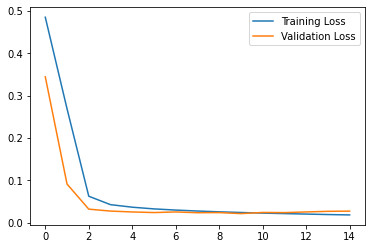

In [30]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

## Detecting anomalies

We will detect anomalies by **determining how well our model can reconstruct
the input data**.


1.   Find the Maximum Absulute Error (MAE) loss on the **training samples**.
2.   This is the worst our model has performed trying
to reconstruct the training samples. We will make this the **`threshold`** for anomaly
detection.
3.   If the reconstruction loss for a **test sample** is greater than this `threshold`
value, then we can infer that the model is seeing a pattern that it isn't
familiar with. We will label this sample as an **`anomaly`**.


In [32]:
# Predictions in the training set
x_train_pred = model.predict(x_train)
print(x_train_pred.shape)

(3745, 288, 1)


In [33]:
# Get train Maximum Absulute Error (MAE) loss for each training instance.
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)
print(train_mae_loss.shape)

(3745, 1)


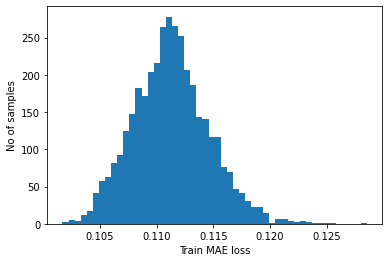

Reconstruction error threshold:  0.12852744352675152


In [34]:

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

### Compare recontruction

Just for fun, let's see how our model has recontructed the first sample.
This is the 288 timesteps from day 1 of our training dataset.

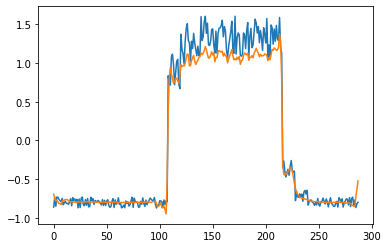

In [35]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

### Prepare test data

In [37]:
df_daily_jumpsup.shape

(4032, 1)

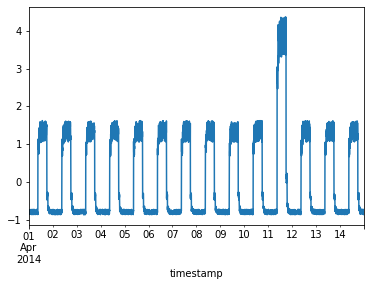

In [36]:
# Normalize the test data with the mean and std of the training data
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()


Break this to multiple shorter time series with length 288

In [38]:
# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)


Test input shape:  (3745, 288, 1)


In [39]:
# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))
test_mae_loss.shape

(3745,)

Plot the test MAE scores

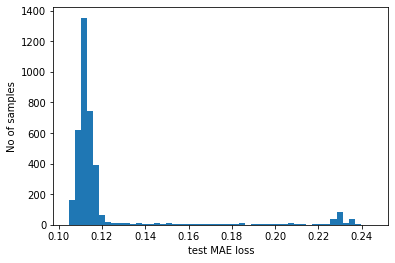

In [40]:
plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()


In [41]:
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  380
Indices of anomaly samples:  (array([2702, 2703, 2704, 2705, 2709, 2710, 2713, 2714, 2715, 2716, 2717,
       2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728,
       2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739,
       2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750,
       2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761,
       2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772,
       2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783,
       2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794,
       2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805,
       2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816,
       2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827,
       2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838,
       2839, 2840, 2841, 2842, 2843, 2844, 2845, 2846, 2847, 2

## Plot anomalies

We now know the samples of the data which are anomalies. With this, we will
find the corresponding `timestamps` from the original test data. We will be
using the following method to do that:

Let's say time_steps = 3 and we have 10 training values. Our `x_train` will
look like this:

- 0, 1, 2
- 1, 2, 3
- 2, 3, 4
- 3, 4, 5
- 4, 5, 6
- 5, 6, 7
- 6, 7, 8
- 7, 8, 9

All except the initial and the final time_steps-1 data values, will appear in
`time_steps` number of samples. So, if we know that the samples
[(3, 4, 5), (4, 5, 6), (5, 6, 7)] are anomalies, we can say that the data point
5 is an anomaly.

In [42]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

Let's overlay the anomalies on the original test data plot.

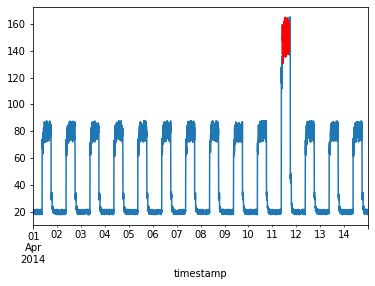

In [43]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()